In [2]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [ ]:
# tải bộ dữ liệu CIFAR-10 từ thư viện Keras 

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
# Chia dữ liệu huấn luyện thành dữ liệu huấn luyện và dữ liệu kiểm tra (validation)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

# test_size=0.1 có nghĩa là 10% của dữ liệu huấn luyện sẽ được chia thành tập kiểm tra
# random_state=0 đảm bảo quá trình chia dữ liệu được tái tạo mỗi lần chạy lại mã

In [ ]:
# In ra kích thước của các tập dữ liệu

print('Train Images Shape:      ', X_train.shape)   # Kích thước của tập hình ảnh huấn luyện
print('Train Labels Shape:      ', y_train.shape)   # Kích thước của tập nhãn huấn luyện

print('\nValidation Images Shape: ', X_valid.shape) # Kích thước của tập hình ảnh kiểm tra (validation)
print('Validation Labels Shape: ', y_valid.shape)   # Kích thước của tập nhãn kiểm tra (validation)

print('\nTest Images Shape:       ', X_test.shape)  # Kích thước của tập hình ảnh thử nghiệm
print('Test Labels Shape:       ', y_test.shape)    # Kích thước của tập nhãn thử nghiệm

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


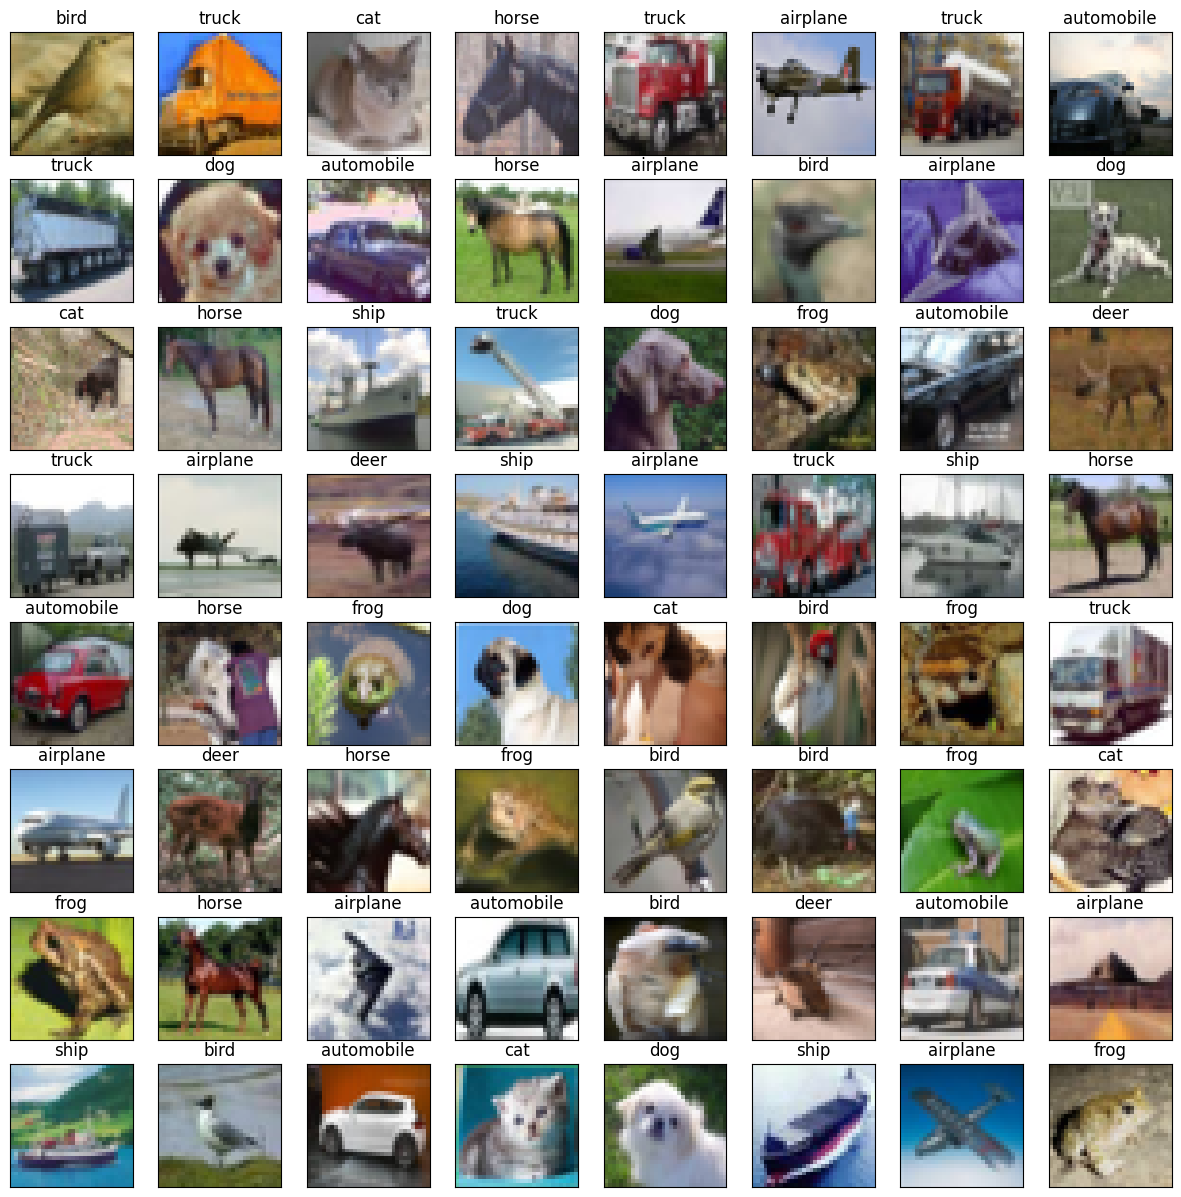

In [ ]:
# Các lớp trong tập dữ liệu CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Tạo một hình mới
plt.figure(figsize=(15,15))

# Lặp qua 25 hình ảnh đầu tiên
for i in range(64):
    # Tạo một biểu đồ con cho mỗi hình ảnh
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Hiển thị hình ảnh
    plt.imshow(X_train[i])

    # Đặt nhãn làm tiêu đề
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Hiển thị hình
plt.show()

In [ ]:
# Chuyển đổi kiểu dữ liệu giá trị pixel thành float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Tính toán giá trị trung bình và độ lệch chuẩn của các hình ảnh huấn luyện
mean = np.mean(X_train)
std  = np.std(X_train)

# Chuẩn hóa dữ liệu
# Giá trị nhỏ 1e-7 được thêm vào để ngăn ngừa chia cho số 0
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [ ]:
y_train = to_categorical(y_train, 10) # Chuyển đổi nhãn của tập huấn luyện thành dạng phân loại one-hot với 10 lớp
y_valid = to_categorical(y_valid, 10) # Chuyển đổi nhãn của tập xác thực thành dạng phân loại one-hot với 10 lớp
y_test  = to_categorical(y_test, 10)  # Chuyển đổi nhãn của tập kiểm tra thành dạng phân loại one-hot với 10 lớp

In [ ]:
# Tăng cường dữ liệu (phương pháp mở rộng tập dữ liệu bằng cách áp dụng các biến đổi ngẫu nhiên lên hình ảnh)

data_generator = ImageDataGenerator(
    # Xoay hình ảnh ngẫu nhiên với góc quay tối đa là 15 độ
    rotation_range=15,
    
    # Di chuyển hình ảnh theo chiều ngang lên đến 12% của chiều rộng hình ảnh
    width_shift_range=0.12,
    
    # Di chuyển hình ảnh theo chiều dọc lên đến 12% của chiều cao hình ảnh
    height_shift_range=0.12,
    
    # Lật hình ảnh ngẫu nhiên theo chiều ngang
    horizontal_flip=True,
    
    # Phóng to hình ảnh lên đến 10%
    zoom_range=0.1,
    
    # Thay đổi độ sáng của hình ảnh lên đến 10%
    brightness_range=[0.9,1.1],

    # Cường độ cắt (góc cắt theo chiều ngược chiều kim đồng hồ tính bằng độ)
    shear_range=10,
    
    # Cường độ thay đổi kênh (thay đổi giá trị màu của kênh màu một cách ngẫu nhiên)
    channel_shift_range=0.1,
)

In [ ]:
# Khởi tạo một mô hình tuần tự (Sequential model) trong Keras
model = Sequential()

# Cài đặt giá trị giảm trọng số (weight decay) cho L2 regularization (Ridge Regularization), giúp giảm overfitting
weight_decay = 0.0001 # Ridge Regularization là một kỹ thuật được sử dụng trong học máy (machine learning) để ngăn ngừa hiện tượng overfitting 

# Thêm lớp convolution đầu tiên với 32 bộ lọc kích thước 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
# sử dụng padding "same" để giữ kích thước ảnh đầu vào và đầu ra giống nhau
# Hàm kích hoạt ReLU được sử dụng, và L2 regularization được áp dụng cho các trọng số

#  Thêm lớp chuẩn hóa batch để giúp mô hình huấn luyện nhanh hơn và ổn định hơn
model.add(BatchNormalization())

# Thêm lớp convolution thứ hai tương tự như lớp đầu tiên
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Thêm lớp max pooling đầu tiên với kích thước pool là 2x2 để giảm chiều rộng và chiều cao của dữ liệu
model.add(MaxPooling2D(pool_size=(2, 2)))

# Thêm lớp dropout với tỷ lệ 0.2, nghĩa là 20% của các neuron sẽ bị tắt trong quá trình huấn luyện để giảm overfitting
model.add(Dropout(rate=0.2))

# Thêm lớp convolution thứ ba và thứ tư với 64 bộ lọc
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Thêm lớp max pooling thứ hai và tăng tỷ lệ dropout lên 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Thêm lớp convolution thứ năm và thứ sáu với 128 bộ lọc
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Thêm lớp max pooling thứ ba và tăng tỷ lệ dropout lên 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Thêm lớp convolution thứ bảy và thứ tám với 256 bộ lọc
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Thêm lớp max pooling thứ tư và tăng tỷ lệ dropout lên 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Chuyển đổi đầu ra của lớp convolutional thành một vector 1 chiều
model.add(Flatten())

# Thêm một lớp fully connected (dense layer) với 10 neuron, dùng hàm kích hoạt softmax để xuất ra xác suất của từng lớp
model.add(Dense(10, activation='softmax'))

# Hiển thị tóm tắt kiến trúc của mô hình
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

- Total params: 1,186,346 (4.53 MB): Tổng tham sô là 1,186,346 với kích thước là 4.53 MB
- Trainable params: 1,184,426 (4.52 MB): Tham số có thể huấn luyện là 1,184,426 với kích thước là 4.52 MB
- Non-trainable params: 1,920 (7.50 KB): Tham số không thể huấn luyện là 1,920 với kích thước là 7.50 KB

In [80]:
# Đặt kích thước (batch size) cho quá trình huấn luyện
batch_size = 64

# Đặt số lượng epoch tối đa cho quá trình huấn luyện
epochs = 20

# Định nghĩa bộ tối ưu hóa (Adam)
optimizer = Adam(learning_rate=0.0005)

# Biên dịch mô hình với bộ tối ưu hóa đã định nghĩa, hàm mất mát (loss function), và các chỉ số (metrics)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Thêm callback ReduceLROnPlateau
# Ở đây, tốc độ học sẽ giảm một nửa (factor=0.5) nếu không có sự cải thiện nào trong mất mát xác thực (validation loss) sau 10 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Thêm callback EarlyStopping
# Ở đây, quá trình huấn luyện sẽ dừng lại nếu không có sự cải thiện nào trong mất mát xác thực (validation loss) sau 40 epoch
# Tham số restore_best_weights đảm bảo rằng trọng số của mô hình sẽ được thiết lập lại 
# theo các giá trị từ epoch có giá trị tốt nhất của chỉ số được theo dõi (trong trường hợp này là 'val_loss')

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Huấn luyện mô hình trên dữ liệu huấn luyện, sử dụng kích thước batch và số lượng epoch đã định nghĩa
# Dữ liệu xác thực (validation data) được sử dụng để đánh giá hiệu suất của mô hình trong quá trình huấn luyện
# Các callback đã triển khai bao gồm việc giảm tốc độ học khi đạt đến mức 
# cao nguyên trong mất mát xác thực và dừng huấn luyện sớm nếu không có sự cải thiện nào được quan sát
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping], 
          verbose=2)

Epoch 1/20
704/704 - 341s - 484ms/step - accuracy: 0.7868 - loss: 0.7971 - val_accuracy: 0.8202 - val_loss: 0.7083 - learning_rate: 5.0000e-04
Epoch 2/20


KeyboardInterrupt: 

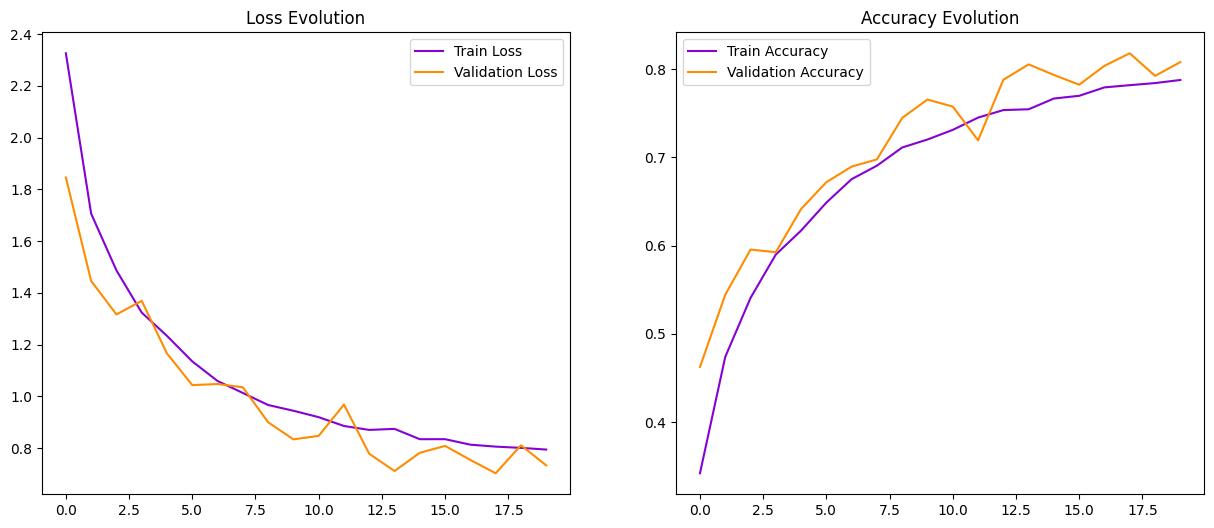

In [ ]:
plt.figure(figsize=(15,6))

# Vẽ đồ thị tổn thất huấn luyện và tổn thất xác thực
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Vẽ đồ thị độ chính xác huấn luyện và độ chính xác xác thực
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [ ]:
# Sử dụng mô hình để đưa ra dự đoán, đánh giá trên dữ liệu kiểm tra
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc) # Độ chính xác của kiểm tra
print('Test Loss:    ', test_loss)  # Tổn thất của kiểm tra

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.8131 - loss: 0.7152

Test Accuracy: 0.8138999938964844
Test Loss:     0.7142716646194458


In [ ]:
# Thêm link ảnh vào url
url = "https://th.bing.com/th/id/OSK.HEROeKOLkXAXbwaGf1uqPK_PtA36DD8hSnrpifsYw9fLj7o?w=312&h=200&c=15&rs=2&o=6&dpr=1.3&pid=SANGAM"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Chuyển ảnh từ định dạng BGR sang RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

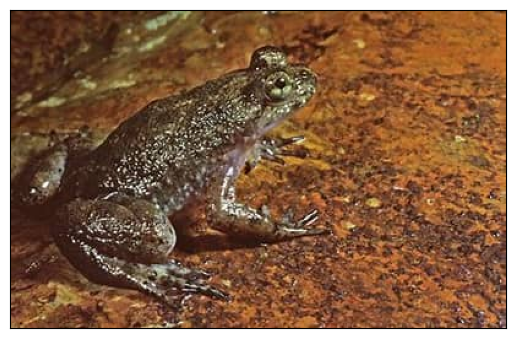

In [ ]:
# Hiển thị ảnh
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [ ]:
# Thay đổi kích thước của ảnh thành 32x32 pixel
image = cv2.resize(image, (32,32))

# Chuẩn hóa ảnh
image = (image-mean)/(std+1e-7)

# Thêm một chiều extra vì mô hình yêu cầu một batch
image = image.reshape((1, 32, 32, 3))

In [ ]:
# Dự đoán lớp của ảnh đầu vào đã được tiền xử lý
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


In [ ]:
# Xác định lớp dự đoán từ kết quả của mô hình và in ra tên lớp tương ứng
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  frog
